# **Preliminary pipeline to calibrate all cameras**

#### The goal of this pipeline is to perform and evaluate the calibration of all cameras for opening track experiments. In order to be able to run it, several prerequisites must be given:

**Synchronized charuco-board recordings:**

Why? Out-of-sync videos can´t be used for calibration, since detected corners of the Charucoboard will be compared across cameras frame by frame. Thus, you must have already synchronized the recordings of the charucoboard with the same fps, e.g. using the `00_synchronize.ipynb` notebook. If not, please synchronize them first! In case any of these videos were cropped, you need to know the cropping indices & whether and how they were flipped.


**Intrinsic camera calibrations:**

In addition to the synchronized Charucoboard recordings to calibrate the cameras to each other, you will also need an intrinsic calibration for each camera. Why? Each camera has a unique distortion of the recorded image that can reduce the calibration quality between multiple cameras. However, you can determine each camera´s unique intrinsic properties & then "invert" these in order to undistort the images. While this can also be done on the Charucoboard recordings within the anipose calibration, it seems to work better using a checkerboard & passing these information along for anipose - especially for a mix of fish-eye and regular cameras. Either option A or option B is required:
- Option A: you have the videos for intrinsic calibration of each camera (uncropped recordings of the checkerboard), then you will have to perform them for each camera
- Option B: these calibrations were already performed and you can simply load the corresponding file for each camera


**Test positions:**

Eventually, you also need some ground truth information to evaluate the calibration. Why? In order to quantify the quality of the calibration, we need some meaningful measurements in addition to the "reprojection error" that anipose returns, which basically tells us the accuracy in units (voxels/pixels?) of the triangulated reference space. Therefore, we triangulate & compute the distances of a certain set of test position markers in the 3D reference space. Since we know the actual distances of these positions, we can compare the measured ground truth distances and the triangulated 3D distances after the calibration & get an error for all distances in cm! For this, you obviously need to know the distances between a certain set of test position markers:
- you either know the distances between certain markers of these test positions, or you can load previously saved test position distances

In addition, you will also need one of the following two options:
- Option A: you have the coordinates of each marker of a test position that is visible in each camera FOV (e.g. from DLC predictions or from tamplate matching)
- Option B: you have images/videos from each camera you would like to calibrate that show the test position markers, then you can manually determine the coordinates of each visible marker id and add it




## Step 1) Create an object that holds the test positions ground truth data:

In [1]:
from gait3d.camera_calibration import TestPositionsGroundTruth
from pathlib import Path

test_positions = TestPositionsGroundTruth()

As mentioned above, you either have the chance to create such an object and feed it with all the distances you measured (and save it to disk, such that you can reuse it the next time), for instance like this:

In [2]:
test_positions.add_new_marker_id(marker_id='screw1_bottom', other_marker_ids_with_distances=[('screw2_bottom', 5),
                                                                                             ('maze_corner_open_left', 19)])

You can find a list of all loaded marker ids and their respective distances to other marker ids in the `.marker_ids_with_distances` attribute. Please note, that reciprocal distances are created automatically & that the distances between the maze corners are preloaded already!

In [3]:
test_positions.marker_ids_with_distances

{'maze_corner_open_left': {'maze_corner_open_right': 4,
  'maze_corner_closed_right': 50.15974481593781,
  'maze_corner_closed_left': 50,
  'screw1_bottom': 19},
 'maze_corner_open_right': {'maze_corner_open_left': 4,
  'maze_corner_closed_right': 50,
  'maze_corner_closed_left': 50.15974481593781},
 'maze_corner_closed_right': {'maze_corner_open_left': 50.15974481593781,
  'maze_corner_open_right': 50,
  'maze_corner_closed_left': 4},
 'maze_corner_closed_left': {'maze_corner_open_left': 50,
  'maze_corner_open_right': 50.15974481593781,
  'maze_corner_closed_right': 4},
 'screw1_bottom': {'screw2_bottom': 5, 'maze_corner_open_left': 19},
 'screw2_bottom': {'screw1_bottom': 5}}

In addition, you have to provide at least one distance between two markers, that you would like as reference distance when the triangulated distances are converted to the unit cm. Since the calibration and thus the triangulation performance can (probably will) be different in different regions of the image, it might make sense to provide several reference distances. During the evaluation later on, all of them will be used to convert the triangulated distances to cm & compare them to the ground truth distances you provided above. If these errors are all relatively low, you know that your calibration worked well across the entire recording space! Please note: the reference distances "maze_length_left" (between "maze_corner_open_left" and "maze_corner_closed_left") & "maze_length_right" (same idea) are again pre-loaded and don´t have to be added:

In [4]:
test_positions.add_marker_ids_and_distance_id_as_reference_distance(marker_ids=('screw1_bottom', 'screw2_bottom'), distance_id='screws_1_2_bottom')

In [5]:
test_positions.reference_distance_ids_with_corresponding_marker_ids

[('maze_length_left', 'maze_corner_open_left', 'maze_corner_closed_left'),
 ('maze_length_right', 'maze_corner_open_right', 'maze_corner_closed_right'),
 ('screws_1_2_bottom', 'screw1_bottom', 'screw2_bottom')]

Finally, if you´d like to have a certain set of marker ids connected in the 3D plot of the triangulation space, feel free to add them like this. Please note, the maze corners will be added automatically again:

In [6]:
test_positions.add_marker_ids_to_be_connected_in_3d_plots(marker_ids=('screw1_bottom', 'screw2_bottom'))

In [7]:
test_positions.marker_ids_to_connect_in_3D_plot

[('maze_corner_open_left',
  'maze_corner_open_right',
  'maze_corner_closed_right',
  'maze_corner_closed_left'),
 ('screw1_bottom', 'screw2_bottom')]

Alright, that´s it! Of course, please add as many marker ids, distances, reference distances & marker id combinations to be connected as you´d like! If you are happy with your `TestPositionsGroundTruth` object, you can save it to disk. Please note, this currently does not save the reference distances or the marker ids you´d like to connect, but solely the marker ids and the distances between them.

In [8]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/test_positions_ground_truth.p')
test_positions.save_to_disk(filepath = filepath)

Well, alternatively, if all these information have already been saved, you can of course simply load them. Please be aware, that only the default reference distances ("maze_length_left" and "maze_length_right") and the default marker ids to connect (all maze corners) will be loaded - however, of course all the marker ids & distances between them are also included:

In [9]:
test_positions_loaded = TestPositionsGroundTruth()
test_positions_loaded.load_from_disk(filepath = filepath)

In [10]:
test_positions_loaded.reference_distance_ids_with_corresponding_marker_ids

[('maze_length_left', 'maze_corner_open_left', 'maze_corner_closed_left'),
 ('maze_length_right', 'maze_corner_open_right', 'maze_corner_closed_right')]

In [11]:
test_positions_loaded.marker_ids_to_connect_in_3D_plot

[('maze_corner_open_left',
  'maze_corner_open_right',
  'maze_corner_closed_right',
  'maze_corner_closed_left')]

In [12]:
test_positions_loaded.marker_ids_with_distances

{'maze_corner_open_left': {'maze_corner_open_right': 4,
  'maze_corner_closed_right': 50.15974481593781,
  'maze_corner_closed_left': 50,
  'screw1_bottom': 19},
 'maze_corner_open_right': {'maze_corner_open_left': 4,
  'maze_corner_closed_right': 50,
  'maze_corner_closed_left': 50.15974481593781},
 'maze_corner_closed_right': {'maze_corner_open_left': 50.15974481593781,
  'maze_corner_open_right': 50,
  'maze_corner_closed_left': 4},
 'maze_corner_closed_left': {'maze_corner_open_left': 50,
  'maze_corner_open_right': 50.15974481593781,
  'maze_corner_closed_right': 4},
 'screw1_bottom': {'screw2_bottom': 5, 'maze_corner_open_left': 19},
 'screw2_bottom': {'screw1_bottom': 5}}

## Step 2) Prepare the data for each single camera you´d like to include in the calibration / triangulation:

The following steps have to be performed for each camera individually, such that you end up with as many `SingleCamDataForAnipose` objects, as you have cameras. Of course, you can adapt the input for each camera individually! Let´s go through the process for the top cam. First, we initialize the object with a unique cam ID and the filepath of the synchronized calibration video that is to be used for the calibration between the set of cameras:

In [13]:
from gait3d.camera_calibration import SingleCamDataForAnipose
from pathlib import Path

In [14]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/220825_Top_Charuco001.AVI')
top_cam = SingleCamDataForAnipose(cam_id = 'Top', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [15]:
top_cam.add_cropping_offsets(x_or_column_offset=0, y_or_row_offset=0)
top_cam.add_flipping_details(flipped_horizontally=False, flipped_vertically=False)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [16]:
filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Top_checkerboard.AVI')
#top_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording, fisheye_cam=False)

... or load it from disk, if you have previously performed the calibration already:

In [17]:
filepath_intrinsic_calibration = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Top_checkerboard_intrinsic_calibration_results.p')
top_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


Great! All relevant metadata are now loaded and stored in the `SingleCamDataForAnipose` object & we will have them readily with us, wherever we move the object - eventually, this will be to the anipose calibration. But before we get there, we have some more work to do. We need to also add the information to our object, which markers of the test positions it can see & where they are in the image. This can be either done automatically (to be implemented / trained) - or manually. For this, we will load the test positions image (or the first frame of the positions video in case of the top cam) from the corresponding camera and manually determine & load the marker ids & their pixel coordinates: 

In [18]:
from gait3d.utils import plot_image, plot_single_frame_of_video

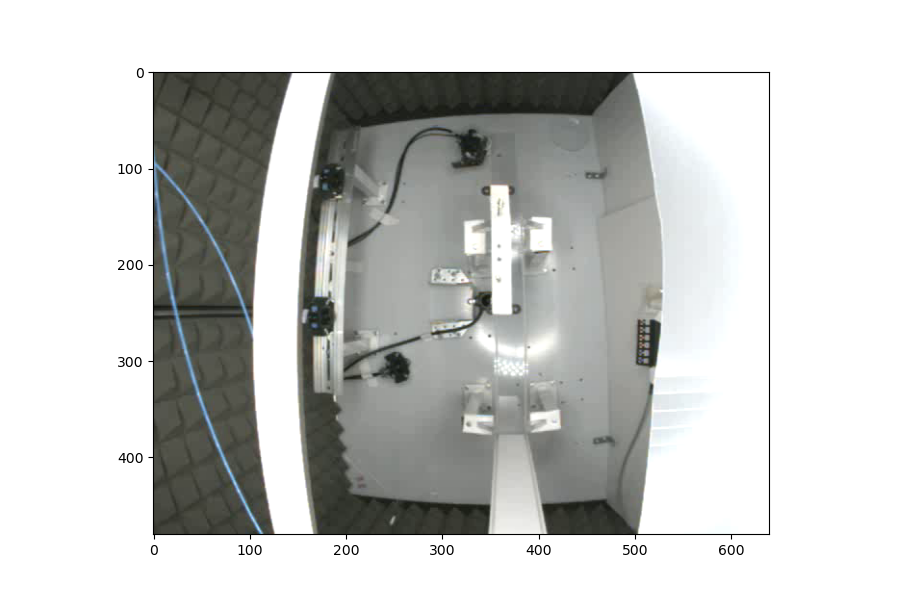

In [19]:
%matplotlib widget
plot_single_frame_of_video(filepath='/mnt/c/Users/dsege/Downloads/220825/220825/220825_Top_Positions002.AVI', frame_idx=0)

In [20]:
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 360 , y_or_row_idx = 375, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_right', x_or_column_idx = 383 , y_or_row_idx = 375, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_left', x_or_column_idx = 360 , y_or_row_idx = 375, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_right', x_or_column_idx = 374 , y_or_row_idx = 63, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'some_random_marker_id', x_or_column_idx = 374 , y_or_row_idx = 63, likelihood=0.999)

In order to save them & also bring them into the correct DataFrame format, run: 

In [21]:
top_cam.save_manual_marker_coords_as_fake_dlc_output()

Your dataframe was successfully saved at: /mnt/c/Users/dsege/Downloads/220825/220825/Top_manual_test_position_marker_fake.h5.
Your "fake DLC marker perdictions" were successfully loaded to the SingleCamDataForAnipose object!


In [22]:
top_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         360  375      0.999   

scorer                                                                         \
bodyparts maze_corner_closed_right                 maze_corner_open_left        
coords                           x    y likelihood                     x    y   
0                              383  375      0.999                   360  375   

scorer                                                      \
bodyparts            maze_corner_open_right                  
coords    likelihood                      x   y likelihood   
0              0.999                    374  63      0.999   

scorer                                          
bodyparts some_random_marker_id                 
coords                        x   y likelihood  
0                           374  63      0.999

Most likely, you will not be able to see all the test position markers from the individual camera FOV. Simply add those that you can see & eventually run the following method to validate them, which: a) adds those markers that are present in the test positions ground truth object but are missing in your current camera object with a likelihood of 0; and b) removes all marker ids that you added to your camera object, but are not present in the ground truth (to avoid typos, ..). Of course, you will be notified:

In [23]:
top_cam.validate_test_position_marker_ids(test_positions_gt=test_positions)

The following marker_ids were missing and added to the dataframe with a likelihood of 0: ['screw1_bottom', 'screw2_bottom'].
The following marker_ids were deleted from the dataframe, since they were not present in the ground truth: ['some_random_marker_id'].


In [24]:
top_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         360  375      0.999   

scorer                                                                         \
bodyparts maze_corner_closed_right                 maze_corner_open_left        
coords                           x    y likelihood                     x    y   
0                              383  375      0.999                   360  375   

scorer                                                                       \
bodyparts            maze_corner_open_right                screw1_bottom      
coords    likelihood                      x   y likelihood             x  y   
0              0.999                    374  63      0.999             0  0   

scorer                                            
bodyparts            screw2_bottom                
coords    likelihood             x  y likelihood  
0                  0             0  0          0

Now we have to repeat this for all individual cameras:


..:

Draft Version:

## For each camera:

In [ ]:
bottom_cam = camera_calibration.SingleCamDataForAnipose(cam_id = 'bottom', filepath = Path('bums'))

In [ ]:
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.save_manual_marker_coords_as_fake_dlc_output()

# or:
bottom_cam.load_test_position_markers_df_from_dlc_prediction()

In [ ]:
bottom_cam.validate_test_position_marker_ids(test_positions_gt = test_positions)

In [ ]:
bottom_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video, fisheye_cam = True, save, max_frame_count = 300)
# or:
bottom_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration)

## Calibration for Anipose

In [ ]:
calibration_for_anipose = CalibrationForAnipose3DTracking(single_cams_to_calibrate = [bottom_cam, top_cam...])
calibration_for_anipose.run_calibration()
calibration_for_anipose.save(filepath)

In [ ]:
calibration_for_anipose.evaluate_triangulation_of_test_position_markers(test_positions_gt = test_positions)